In [1]:
import string
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from collections import Counter
import datetime
import pandas as pd
import numpy as np
import umap
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy import sparse
import matrix
import logger

C:\Users\karamov\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll   0
C:\Users\karamov\AppData\Roaming\Python\Python37\site-packages\llvmlite\binding\llvmlite.dll   0


In [31]:
def get_terms(topic_number, corpus, component):
    component_for_topic = component[topic_number, :][0]
    corpus_weight_for_topic = zip(corpus, component_for_topic)
    return np.array(sorted(corpus_weight_for_topic, key=lambda x: x[1], reverse=True)[:30])[:, 0]


def get_top_terms_for_even_documents(svd, component, corpus):
    significant_topic_for_each_row = np.argmax(svd, axis=1).reshape((svd.shape[0], 1))
    return np.apply_along_axis(get_terms, 1, significant_topic_for_each_row, corpus, component)
    
def fit_transform_embedding(matrix_documents, terms, topic_count=10, max_iter=30, doc_topic_prior=0.05, topic_word_prior=0.05, evaluate_every=1):
    logger.log('start')    
    origignal_matrix = matrix_documents.toarray()
    from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
    lda = LatentDirichletAllocation(n_components=topic_count, random_state=0, max_iter=max_iter, doc_topic_prior=doc_topic_prior, topic_word_prior=topic_word_prior, evaluate_every=evaluate_every)
    topics = lda.fit_transform(origignal_matrix)
    components = lda.components_


    top_terms = get_top_terms_for_even_documents(topics, components, terms)
    embedding = TSNE(n_components=2,random_state=5).fit_transform(topics)
    logger.log('end')
    return top_terms, embedding ,topics, components
    

In [29]:
matrix_documents, terms = matrix.read_matrix()
top_terms, embedding, topics, components  = fit_transform_embedding(matrix_documents, terms, topic_count=25)

In [15]:
def print_topics(count_related_words, components, terms):
    for i, comp in enumerate(components):
        terms_comp = zip(terms, comp)
        sorted_terms = sorted(terms_comp, key=lambda x: x[1], reverse=True)[:count_related_words]
        topic = "Topic " + str(i) + ": "
        for sorted_term in sorted_terms:
            topic = topic + sorted_term[0] + ' '
        print()
        print(topic)

def visualize_topic(top_terms, embedding, topics):
    clusters_by_topics = np.argmax(topics, axis=1).reshape((topics.shape[0], 1))
    df = pd.DataFrame(clusters_by_topics, columns=['cluster_n'])
    df['Id'] = np.arange(len(df))
    df['x'] = embedding[:, 0]
    df['y'] = embedding[:, 1]

    plt.figure(figsize=(20, 15))
    group_by_cluster = df.groupby('cluster_n')
    print(len(group_by_cluster))
    for name, group in group_by_cluster:        
        c = np.array([np.random.rand(3,)]* len(group['Id']))
        plt.scatter(group['x'], group['y'],
                s=20,
                c=c,
                edgecolor='none',
               label=name)
    
        plt.legend(fontsize=12)
        
def print_education_program_name_by_topic(topics, name):
    clusters_by_topics = np.argmax(topics, axis=1).reshape((topics.shape[0], 1))
    df = pd.DataFrame(clusters_by_topics, columns=['cluster_n'])
    df['name'] = name
    group_by_cluster = df.groupby('cluster_n')
    topic_number = 0
    for name, group in group_by_cluster:
        name_by_group = []
        for program_name in group['name']:
            name_by_group.append(str(program_name))
        print('Topic {}: {}'.format(topic_number,';'.join(name_by_group)))
        topic_number = topic_number + 1
        
    


Topic 0: администрирование linux система мониторинг сервер инфраструктура настройка ос bash сервис python поддержка ansible ci база развёртывание docker субд виртуализация решение postgresql zabbix автоматизация devops сетевой скрипт язык cd oracle резервный технология приложение windows nginx производительность технический копирование системный администратор управление бд vmware unix сопровождение уровень принцип kubernetes обеспечение платформа навык процесс команда mysql плюс задача написание centos проблема скриптовый серверный apache облачный инженер sql эксплуатация jenkins развитие внедрение компания проект 

Topic 1: 1с предприятие учёт erp внедрение проект платформа автоматизация конфигурация компания бухгалтерский программист бизнес задача система специалист зарплата управление фирма сертификат консультант программный решение заказчик бухгалтерия типовой область производственный сопровождение участие технический корп налоговый пользователь задание управленческий продукт зуп 

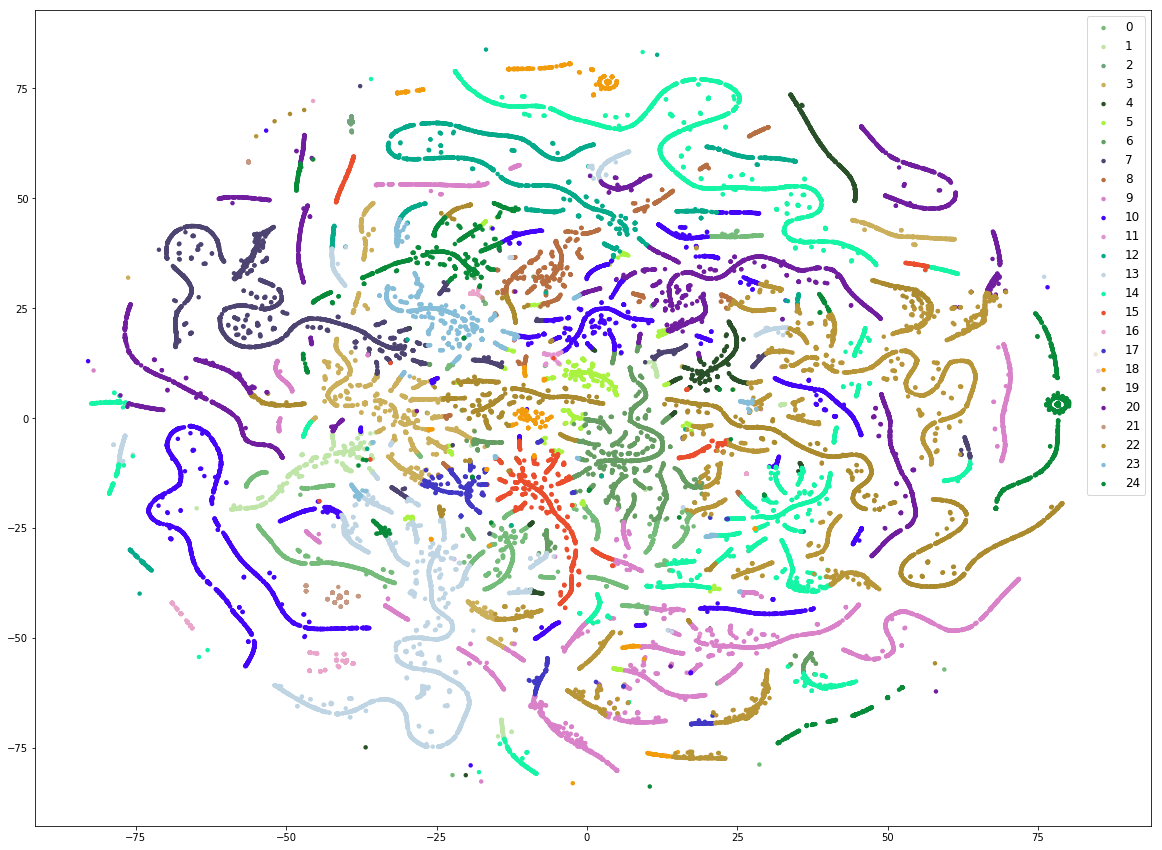

In [31]:
visualize_topic(top_terms, embedding, topics)
print_topics(70,components, terms)

In [36]:
matrix_documents_ed, terms_ed = matrix.read_matrix('./ed_matrix')

education_program_name = pd.read_csv('./ed.csv')['name']
top_terms_ed, embedding_ed, topics_ed, components_ed  = fit_transform_embedding(matrix_documents_ed, terms_ed,topic_count=25, max_iter=30, doc_topic_prior=0.03, topic_word_prior=0.03, evaluate_every=1)
print('----Топики по документам----')
print_education_program_name_by_topic(topics_ed, education_program_name)
print('\n----Топики по словам----')
print_topics(70,components_ed, terms_ed)

2020-05-16 14:18:03 - start
2020-05-16 14:18:06 - end
----Топики по документам----
Topic 0: Интеллектуальные методы анализа информации;Администрирование информационных систем
Topic 1: Системы связи
Topic 2: Основы информационных процессов;Криминалистические методы информационной безопасности;Проектирование программного обеспечения;Автоматизированные управляющие и информационные системы
Topic 3: Базы данных и знаний;Проектирование микропроцессорных систем;Управление проектами информационных систем
Topic 4: Безопасность сетевых технологий;Безопасные автоматизированные системы;Инженерно-техническая защита информации;Методы и средства борьбы с компьютерной преступностью;Методы и средства защиты документооборота;Программно-алгоритмическое обеспечение информационной безопасности;Программно-аппаратные средства защиты информации;Измерительные информационные системы;Концепции современного программирования;Корпоративные информационные системы;Многоуровневые и мобильные приложения;Промышленные ба

In [37]:
matrix_documents_ed, terms_ed = matrix.read_matrix('./ed_matrix_dist')

education_program_name = pd.read_csv('./ed_by_dist.csv')['name']
top_terms_ed, embedding_ed, topics_ed, components_ed  = fit_transform_embedding(matrix_documents_ed, terms_ed,topic_count=25, max_iter=30, doc_topic_prior=0.06, topic_word_prior=0.06, evaluate_every=1)
print('----Топики по документам----')
print_education_program_name_by_topic(topics_ed, education_program_name)
print('\n----Топики по словам----')
print_topics(70,components_ed, terms_ed)

2020-05-16 14:18:22 - start
2020-05-16 14:18:25 - end
----Топики по документам----
Topic 0: дискретная математика и математическая логика;управление ит-проектами;аппаратные интерфейсы общего и промышленного назначения;основы теории управления;«информационная безопасность распределенных систем»;проектирование автоматизированных систем обработки информации и управления;конструкторско-технологическое обеспечение производства эвм;основы машинного обучения
Topic 1: «безопасность операционных систем»;«операционные системы»;«противодействие вредоносным программам»;сетевое программное обеспечение;электромагнитные поля и волны;основы информационно-коммуникационных технологий и сетевое администрирование;построение масштабируемых сетей;«безопасность операционных систем»;«операционные системы»
Topic 2: «криптографические методы и средства защиты информации»
Topic 3: «сетевые технологии»;«аппаратные средства вычислительной техники»;« проектирование защищенных автоматизированных систем»;«техническая